# Bayesian Gaussian Mixture Modeling using TensorFlow Probability

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tf.compat.v1.enable_eager_execution()

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

print('TensorFlow version:', tf.__version__)
print('TensorFlow Probability version:', tfp.__version__)


  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  
TensorFlow version: 1.15.0-dev20190821
TensorFlow Probability version: 0.8.0-dev20190828


## Generate some data

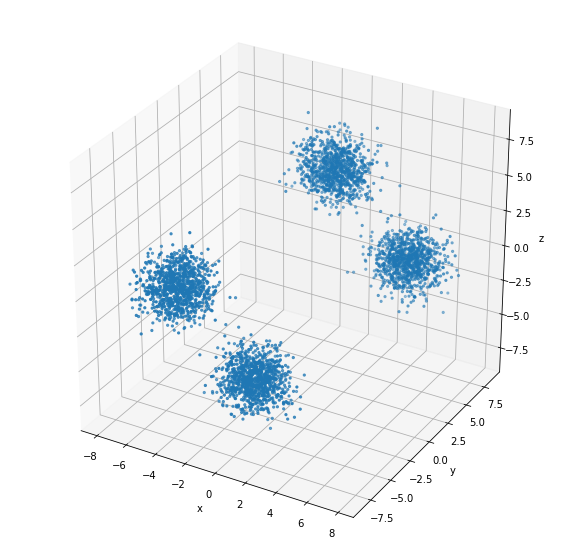

In [2]:
n_samples_per_class = 1000
n_dims = 3
n_classes = 4
n_samples = n_samples_per_class * n_classes

X = np.random.randn(n_samples, n_dims).astype('float32')

X[:n_samples_per_class, :] += [5, 5, 0]
X[n_samples_per_class:2 * n_samples_per_class, :] += [-5, -5, 0]
X[2 * n_samples_per_class:3 * n_samples_per_class, :] += [0, 5, 5]
X[3 * n_samples_per_class:, :] += [0, -5, -5]

# Plot the data
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter(X[:, :1], X[:, 1:2], X[:, 2:], marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

## Make a TensorFlow Dataset from that data

In [3]:
batch_size = 500
dataset = tf.data.Dataset.from_tensor_slices((X)).shuffle(10000).batch(batch_size)

## Build a Gaussian Mixture Model via model subclassing

In [4]:
class GaussianMixtureModel(tf.keras.Model):
    """A Bayesian Gaussian mixture model.
    
    Assumes Gaussians' variances in each dimension are independent.
    
    Parameters
    ----------
    n_components : int > 0
        Number of mixture components.
    n_dims : int > 0
        Number of dimensions.
    """
    def __init__(self, n_components, n_dims):
        # Initialize
        super(GaussianMixtureModel, self).__init__()
        self.n_components = n_components
        self.n_dims = n_dims
        
        # Variational posterior distribution variables for means
        self.locs = tf.Variable(tf.random.normal((n_components, n_dims)), name='locs')
        # no inverse gamma in tf.random, has to use sigma^{-2} ~ Gamma
        self.scales = tf.Variable(1 / tf.sqrt(tf.random.gamma((n_components, n_dims), 10, 10)), name='scales')
        
        # Variational posterior distribution variables for standard deviations
        self.alpha = tf.Variable(tf.random.uniform((n_components, n_dims), 9, 11), name='alpha')
        self.beta = tf.Variable(tf.random.uniform((n_components, n_dims), 9, 11), name='beta')
        
        # Variational posterior distribution variables for component weights
        self.counts = tf.Variable(5 * tf.ones((n_components,)), name='counts')

        # Prior distributions for the means
        self.mu_prior = tfd.Normal(tf.zeros((n_components, n_dims)), tf.ones((n_components, n_dims)))

        # Prior distributions for the standard deviations
        self.sigma_negsq_prior = tfd.Gamma(10 * tf.ones((n_components, n_dims)), 10 * tf.ones((n_components, n_dims)))
        
        # Prior distributions for the component weights
        self.theta_prior = tfd.Dirichlet(5 * tf.ones((n_components,)))
        
    def call(self, x, sampling=True):
        """Compute losses given a batch of data.
        
        Parameters
        ----------
        x : tf.Tensor
            A batch of data
        sampling : bool
            Whether to sample from the variational posterior
            distributions (if True, the default), or just use the
            mean of the variational distributions (if False).
            
        Returns
        -------
        log_likelihoods : tf.Tensor
            Log likelihood for each sample
        kl_sum : tf.Tensor
            Sum of the KL divergences between the variational
            distributions and their priors
        """
        
        # The variational distributions
        mu = tfd.Normal(self.locs, self.scales)
        sigma_neqsq = tfd.Gamma(self.alpha, self.beta)  # sigma^{-2}
        theta = tfd.Dirichlet(self.counts)
        
        # Sample from the variational distributions
        if sampling:
            batch_size = x.shape[0] # number of samples in the batch
            mu_sample = mu.sample(batch_size)
            sigma_sample = 1 / tf.sqrt(sigma_neqsq.sample(batch_size))
            theta_sample = theta.sample(batch_size)
        else:
            mu_sample = tf.reshape(mu.mean(), (1, self.n_components, self.n_dims))
            sigma_sample = 1 / tf.sqrt(tf.reshape(sigma_neqsq.mean(), (1, self.n_components, self.n_dims)))
            theta_sample = tf.reshape(theta.mean(), (1, self.n_components))
        
        # The mixture density
        density = tfd.Mixture(cat=tfd.Categorical(probs=theta_sample),
                              components=[tfd.MultivariateNormalDiag(loc=mu_sample[:, i, :],
                                                                     scale_diag=sigma_sample[:, i, :]) 
                                          for i in range(self.n_components)])
                
        # Compute the mean log likelihood
        log_likelihoods = density.log_prob(x)
        
        # Compute the KL divergence sum
        div_mu = tf.reduce_sum(tfd.kl_divergence(mu, self.mu_prior))
        div_sigma = tf.reduce_sum(tfd.kl_divergence(sigma_neqsq, self.sigma_negsq_prior))
        div_theta = tf.reduce_sum(tfd.kl_divergence(theta, self.theta_prior))
        kl_sum = div_mu + div_sigma + div_theta
        
        # Return both losses
        return log_likelihoods, kl_sum
    
# model instantiation
model = GaussianMixtureModel(n_classes, n_dims)

## Model fitting

In [5]:
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(lr=lr)

loss_nll = tf.keras.metrics.Mean(name='negative_log_likelihoods')
loss_kl = tf.keras.metrics.Mean(name='KL_divergence')
loss_train = tf.keras.metrics.Mean(name='loss_train')

@tf.function
def train_step(data):
    with tf.GradientTape() as tape:
        log_likelihoods, kl_sum = model(data)
        neg_elbo = kl_sum/n_samples - tf.reduce_mean(log_likelihoods)
    tvars = model.trainable_variables
    gradients = tape.gradient(neg_elbo, tvars)
    optimizer.apply_gradients(zip(gradients, tvars))
    # record metrics
    loss_nll(-tf.reduce_mean(log_likelihoods))
    loss_kl(kl_sum)
    loss_train(neg_elbo)
    
# Fit the model
n_epochs = 2000
n_epochs_per_print = 50
for epoch in range(n_epochs):
    for data in dataset:
        train_step(data)
    if (epoch + 1) % n_epochs_per_print == 0:
        print('Epoch {}: nll = {:.4f}, kl = {:.4f}, -elbo = {:.4f}'.format(epoch+1,
                                                                           loss_nll.result(),
                                                                           loss_kl.result(),
                                                                           loss_train.result()))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 50: nll = 21.6200, kl = 7.2044, -elbo = 21.6218
Epoch 100: nll = 20.0848, kl = 9.3631, -elbo = 20.0872
Epoch 150: nll = 18.6989, kl = 12.2620, -elbo = 18.7020
Epoch 200: nll = 17.4805, kl = 15.7800, -elbo = 17.4844
Epoch 250: nll = 16.4124, kl = 19.9012, -elbo = 16.4174
Epoch 300: nll = 15.4665, kl = 24.6428, -elbo = 15.4727
Epoch 350: nll = 14.6149, kl = 30.0348, -elbo = 14.6224
Epoch 400: nll = 13.8554, kl = 35.9967, -elbo = 13.8644
Epoch 450: nll = 13.1952, kl = 42.0960, -elbo = 13.2057
Epoch 500: nll = 12.6251, kl = 48.0105, -elbo = 12.6371
Epoch 550: nll = 12.1323, kl = 53.6769, -elbo = 12.1458
Epoch 600: nll = 11.7041, kl = 58.9527, -elbo = 11.7189
Epoch 650: nll = 11.3300, kl = 63.7538, -elbo = 11.3460
Epoch 700: nll = 11.0000, kl = 68.0788, -elbo = 11.0171
Epoch 750: nll = 10.7052, kl = 72.0024, -elbo = 10.7233
Epoch 800: nll = 10.4366, kl = 75.5884, -elbo = 10.4555
Epoch 850: nl

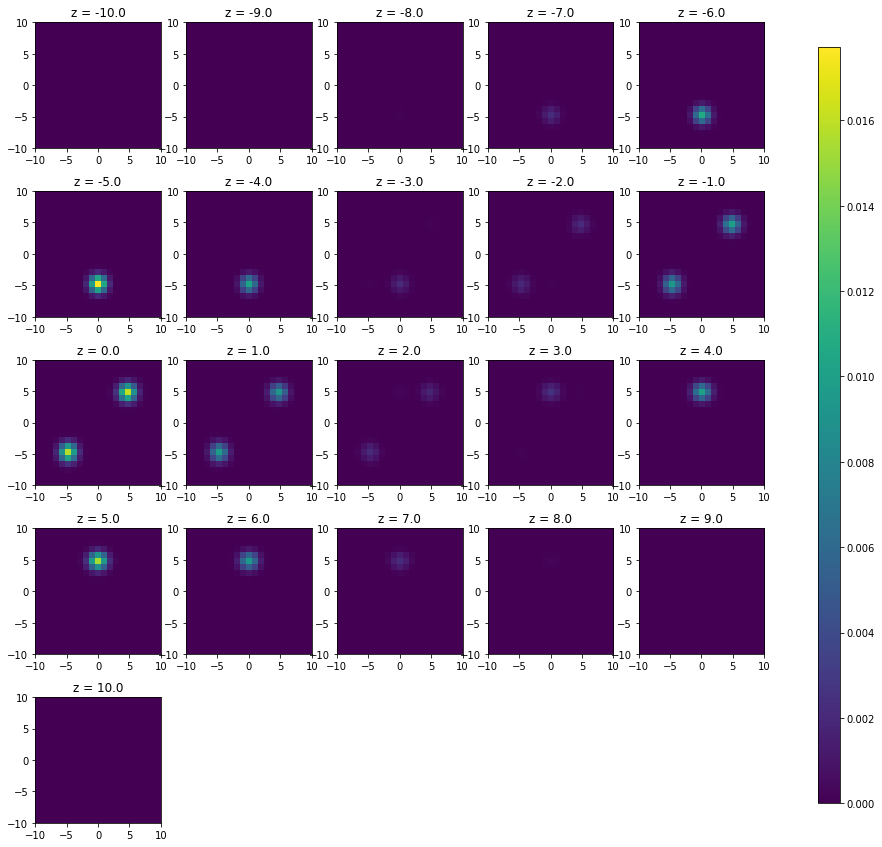

In [6]:
# Compute log likelihood at each point on a grid
n_grids = 21 # number of grid points
x_, y_, z_ = np.linspace(-10, 10, n_grids), np.linspace(-10, 10, n_grids), np.linspace(-10, 10, n_grids)
x_grid, y_grid, z_grid = np.meshgrid(x_, y_, z_)
grids = np.column_stack([x_grid.flatten(), y_grid.flatten(), z_grid.flatten()])
ll, _ = model(grids.astype('float32'), sampling=False)
ll = np.reshape(ll, (n_grids, n_grids, n_grids))
        
# Show the fit mixture density (slices of z-axis)
n_subplot_rows = 5
fig, ax = plt.subplots(n_subplot_rows, n_grids // n_subplot_rows + 1, figsize=(15, 15))
for i in range(n_subplot_rows):
    for j in range(n_grids // n_subplot_rows + 1):
        idx = i * (n_grids // n_subplot_rows + 1) + j
        if idx < n_grids:
            im = ax[i, j].imshow(np.exp(ll)[:, :, idx], extent=(-10, 10, -10, 10), origin='lower',
                                 vmin=0, vmax=np.exp(ll).max())
            ax[i, j].title.set_text('z = {}'.format(z_[idx]))
        else:
            ax[i, j].axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

## Output trainable variables

In [7]:
{v.name: v.numpy() for v in model.trainable_variables}

{'locs:0': array([[ 0.03009757, -4.984504  , -5.0234427 ],
        [-4.9594235 , -5.0404253 ,  0.01858917],
        [ 4.9221435 ,  4.936357  , -0.03691473],
        [-0.00790328,  5.0284047 ,  4.9690557 ]], dtype=float32),
 'scales:0': array([[0.0328973 , 0.0213622 , 0.03890092],
        [0.03521341, 0.03515304, 0.02957125],
        [0.03662761, 0.02574338, 0.02859616],
        [0.03131373, 0.03519414, 0.03760857]], dtype=float32),
 'alpha:0': array([[11.850031, 11.305192, 10.713063],
        [11.291679, 11.408617, 11.927823],
        [11.834936, 10.460478, 11.511527],
        [10.359543, 11.494308,  9.557613]], dtype=float32),
 'beta:0': array([[10.722033, 10.381529, 10.358397],
        [10.882269, 12.146203, 11.889803],
        [11.734924, 10.231582, 11.038829],
        [11.050535, 10.808798, 10.431531]], dtype=float32),
 'counts:0': array([10.572541, 10.620061, 10.37147 , 10.681875], dtype=float32)}

## Pairwise plot

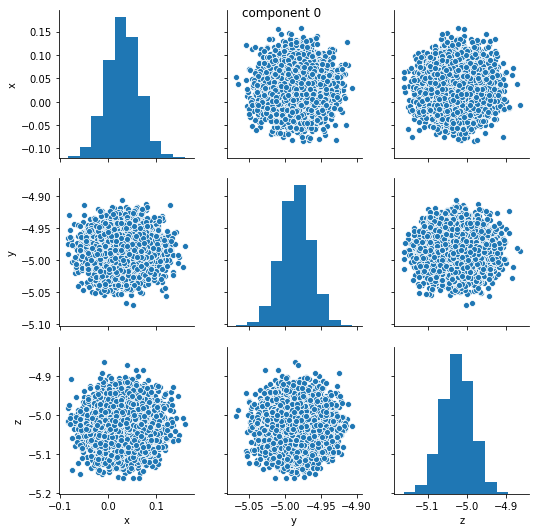

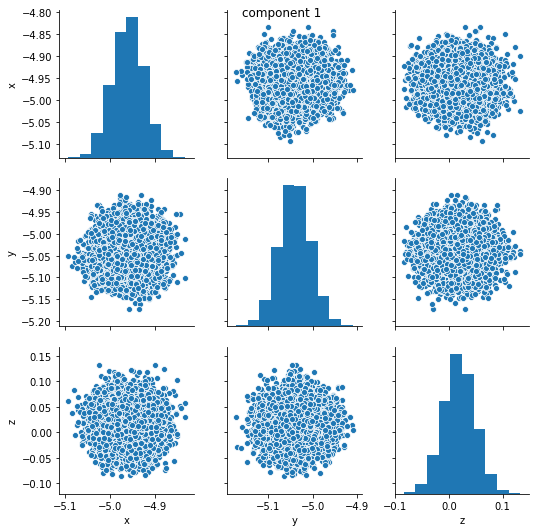

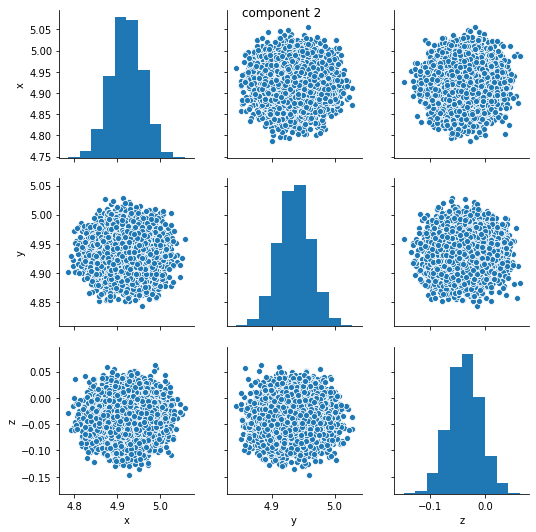

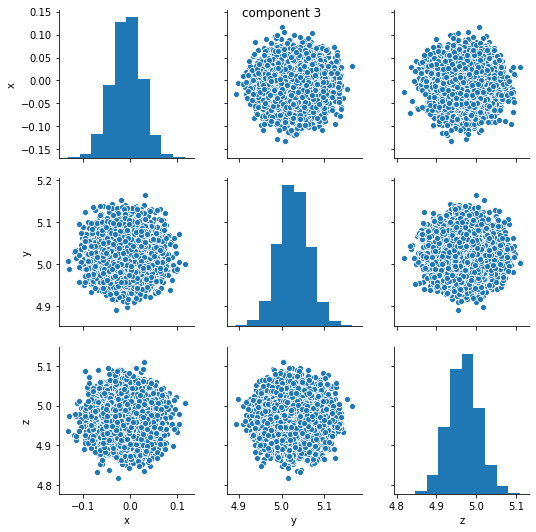

In [8]:
mu_samples = tfd.Normal(model.locs, model.scales).sample(10000)
for c in range(n_classes):
    mu_dataset = pd.DataFrame({'x': mu_samples.numpy()[:, c, 0],
                               'y': mu_samples.numpy()[:, c, 1],
                               'z': mu_samples.numpy()[:, c, 2]})
    fig_sns = sns.pairplot(mu_dataset)
    fig_sns.fig.suptitle('component {}'.format(c))